# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание проекта:** предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Цель исследования:** Необходимо решить где бурить новую скважину.

**Ход исследования:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Общий вывод:** резюмирование полуенных результатов, формулировка ключевых выводов и результатов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from tqdm import tqdm

RANDOM = 42
state = RandomState(RANDOM) 

In [2]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def information(df):
    display(df.head())
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())

In [3]:
# Функция создает для списка столбцов два графика - гистограмму и ящик с усами.
def todoplot(df):
    for i in col:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

In [4]:
# Функция удаляет вбросы.
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [5]:
#Функция для прибыли по выбранным скважинам.
def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:FINAL_MAX_POINTS]
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * PRICE_PER_BARREL) - BUDGET_PER_REGION,2)

In [6]:
# Функция для расчета риска.
def confidence_interval(true_target,pred_target):
    samples = []
    for i in tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n = PRE_MAX_POINTS, replace=True, random_state=state)
        samples.append(income(true_target,sample))
    samples = pd.Series(samples)
    print(samples.mean())
    print(samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

## Загрузка и подготовка данных

### Загрузим данные

In [7]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Подготовим данные

#### Проверим данные на пропуски и дубликатов

In [8]:
information(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [9]:
information(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [10]:
information(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


#### Проверим данные на наличие аномалий

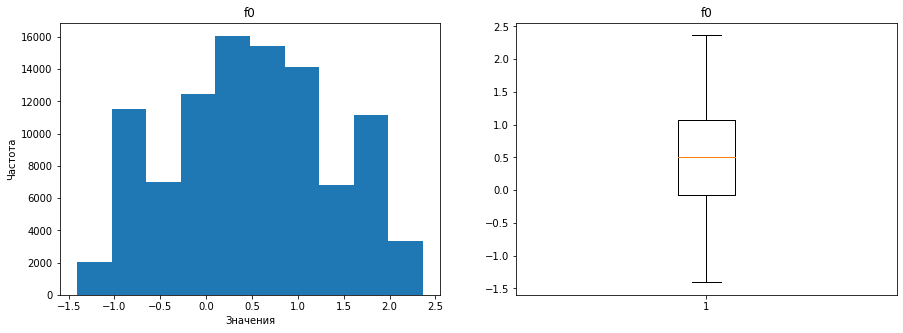

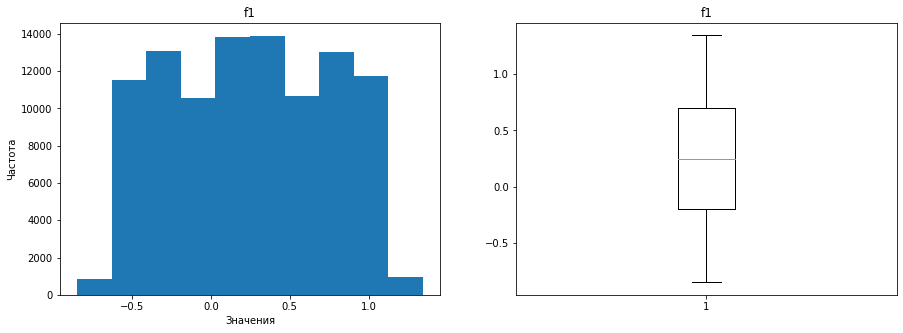

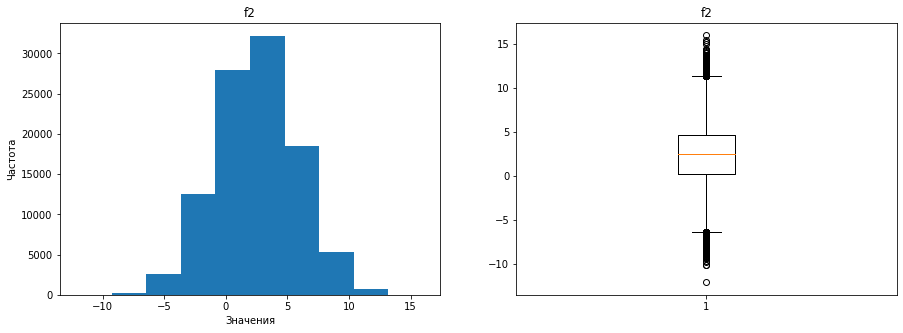

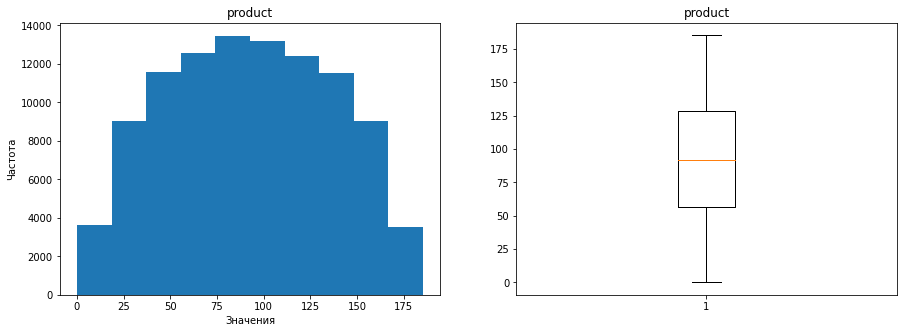

In [11]:
col = ['f0', 'f1', 'f2', 'product']
todoplot(data_0)

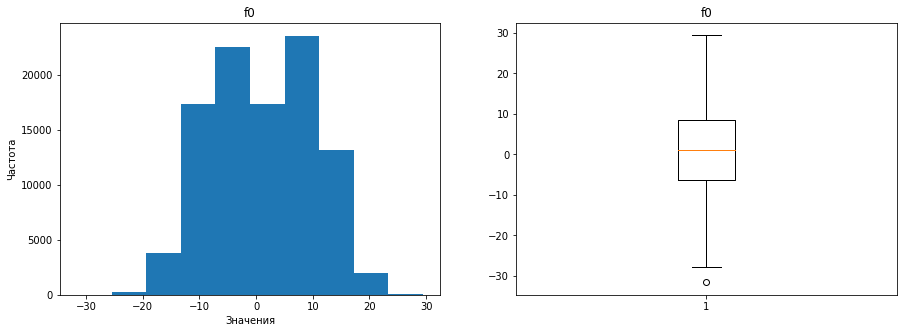

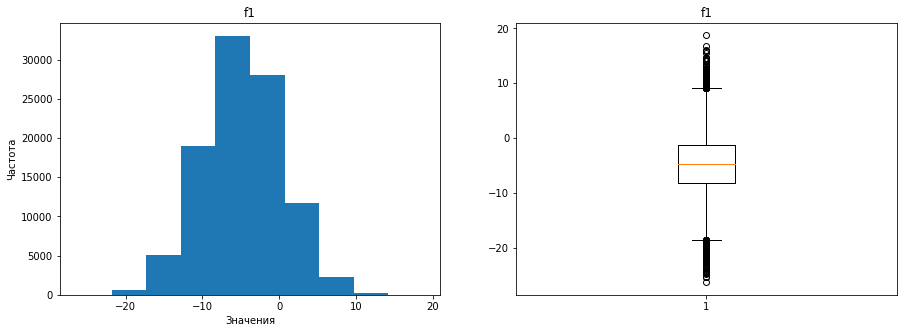

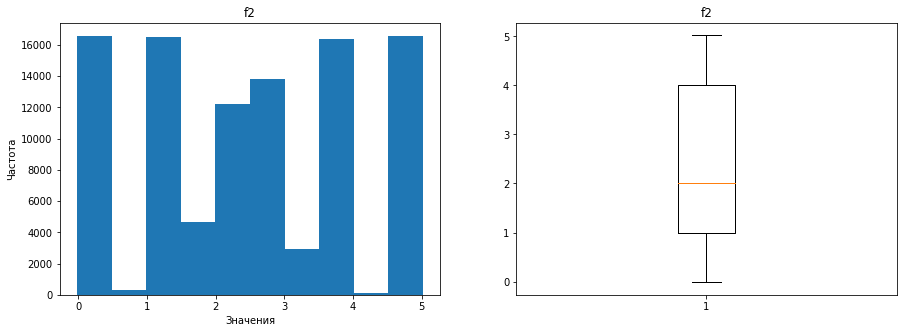

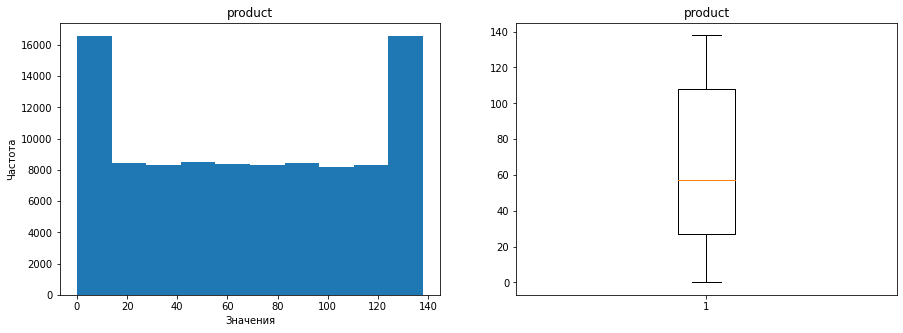

In [12]:
col = ['f0', 'f1', 'f2', 'product']
todoplot(data_1)

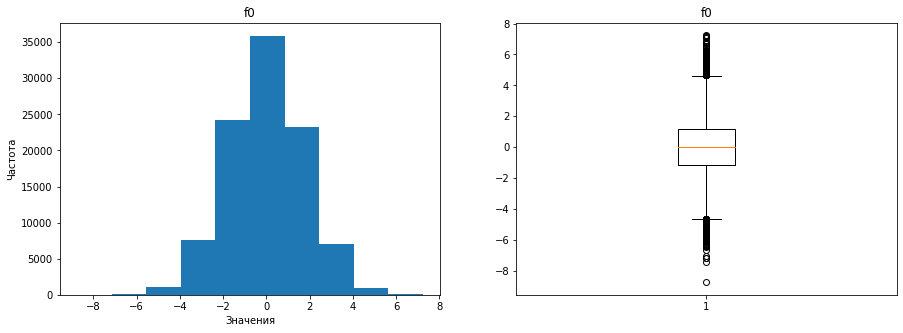

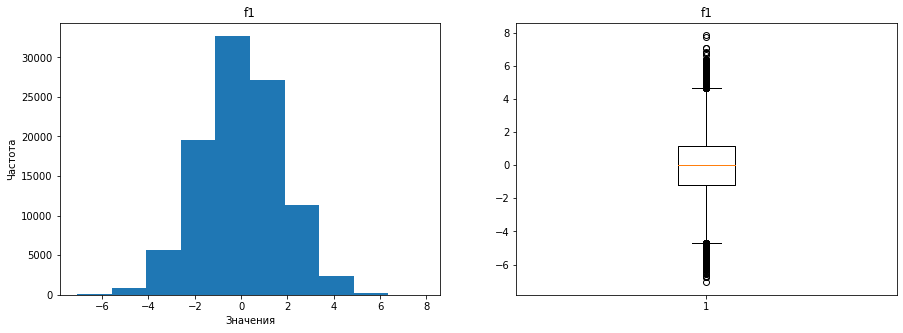

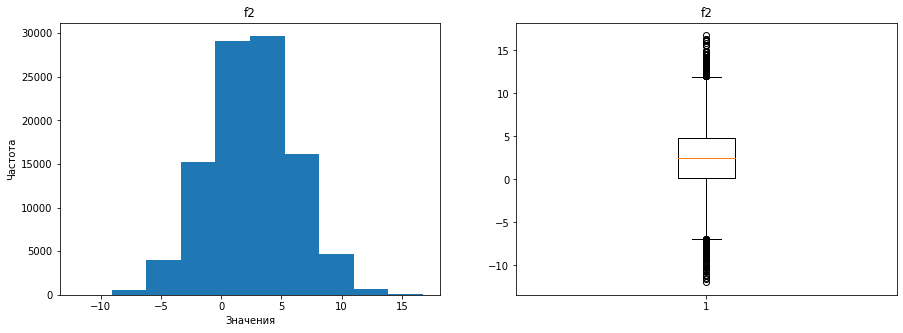

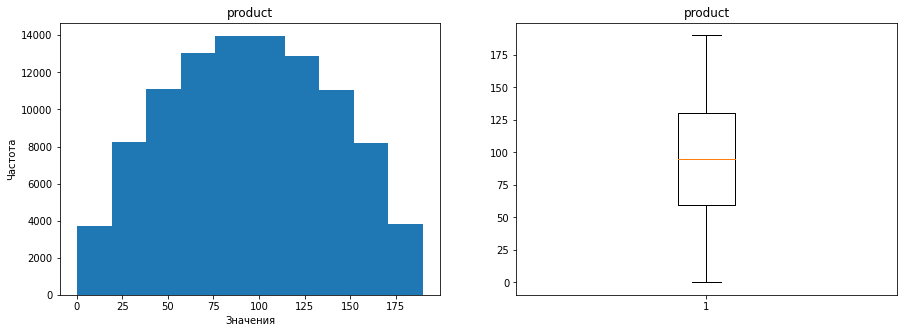

In [13]:
col = ['f0', 'f1', 'f2', 'product']
todoplot(data_2)

**Выводы**:

1. В датафреймах отсутствуют дубликаты и тип данных в столбцах корректный;

2. В датафреймах присутвуют вбросы.

#### Проверим корреляцию между признаками

In [14]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [15]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [16]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Выводы**:

Заметим, что в нулевом фрейме признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком. Так же в первом фрейме очень сильно коррелирует целевой признак и f2. Во втором фрейме так же есть коррелирующие признаки, такие как f2 и product.

Если в случае с первым фреймом все достаточно понятно, там очень высокая корреляция и признак f2 следует удалить, то вот в случае с другими двумя выборками стоит опираться на результат, который мы получим на моделях, Следовательно необходимо подготовить 3 выборок:

Нулевая со всеми столбцами

Первая со всеми столбцами

Вторая со всеми столбцами

**Общий вывод к 1-му разделу**:

1. Пропуски - отсутствуют
2. Типы столбцов - корректны
3. Названия столбцов - корректны
4. Дубликаты - отсутствуют
5. Объем запасов - положительный

## Обучение и проверка модели

### Разобьем данные на обучающую и валидационую выборки. Также обучем модель, сделаем предсказание на валидационной выборке и сохраним результат

In [17]:
array_name = ["data_0",
              "data_2",
              "data_1"]

array_frame = [data_0,
              data_2,
              data_1]

data_dict = {"pipelines":{},"scores":{},"valid":{}}

for frame, name in zip(array_frame, array_name):
    
    features = frame.drop(["id", "product"], axis = 1)
    target = frame["product"]
    
    new_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    
    
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,
                                     target,
                                     test_size = 0.25,
                                     random_state = RANDOM)
    data_dict['valid'][name] = (features_valid,target_valid)
    new_pipeline.fit(features_train,target_train)
    
    data_dict['pipelines'][name] = new_pipeline
    data_dict['scores'][name] = mean_squared_error(target_valid,
                                                   new_pipeline.predict(features_valid))**0.5

In [18]:
data_dict['scores']

{'data_0': 37.75660035026169,
 'data_2': 40.145872311342174,
 'data_1': 0.8902801001028846}

Выборка с минимальной ошибкой:

1. Первый регион: 'data_1'
2. Нулевой регион: 'data_0'
3. Второй регион: 'data_2'

### Выведем на экран средний запас предсказанного сырья и RMSE

In [19]:
predicted_values_zero = data_dict['pipelines']['data_0'].predict(data_dict['valid']['data_0'][0])
predicted_values_first = data_dict['pipelines']['data_1'].predict(data_dict['valid']['data_1'][0])
predicted_values_second = data_dict['pipelines']['data_2'].predict(data_dict['valid']['data_2'][0])

RMSE_model_zero = (mean_squared_error(data_dict['valid']['data_0'][1], predicted_values_zero))**0.5
RMSE_model_first = (mean_squared_error(data_dict['valid']['data_1'][1], predicted_values_first))**0.5
RMSE_model_second = (mean_squared_error(data_dict['valid']['data_2'][1], predicted_values_second))**0.5

In [20]:
print(f'Нулевой регион: средний запас {predicted_values_zero.mean()}; RMSE {RMSE_model_zero}\n',
      f'Первый регион: средний запас {predicted_values_first.mean()}; RMSE {RMSE_model_first}\n',
      f'Второй регион: средний запас {predicted_values_second.mean()}; RMSE {RMSE_model_second}\n',
     )

Нулевой регион: средний запас 92.39879990657768; RMSE 37.75660035026169
 Первый регион: средний запас 68.7128780391376; RMSE 0.8902801001028846
 Второй регион: средний запас 94.77102387765939; RMSE 40.145872311342174



**Вывод ко 2-му разделу**:

- Нулевой регион:
Ошибка в нулевом регионе на втором и по среднему объему запасов регион на втором месте

- Первый регион:
Ошибка в первом регионе самая маленькая, но по среднему объему запасов регион на последнем месте

- Второй регион:
Самый большой средний объем запасов, но по ошибке регион на последнем месте

## Подготовка к расчёту прибыли

### Сохраним все ключевые значения в отдельных переменных и рассчитаем достаточный объем для безубыточной разработки новой скважины

In [21]:
BUDGET_PER_REGION = 10*(10**9)
PRE_MAX_POINTS = 500
FINAL_MAX_POINTS = 200
PRICE_PER_BARREL = 450000
DAMAGE_THRESHOLD =  0.025
NON_DAMAGE_POINT = (BUDGET_PER_REGION/(PRICE_PER_BARREL*(10**3)))/(FINAL_MAX_POINTS)

In [22]:
print("Достаточный объем добычи для безубыточной разработки", round(NON_DAMAGE_POINT,2))

Достаточный объем добычи для безубыточной разработки 0.11


### Сравним достаточный объем со средним объемом добычи в регионах

In [23]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [24]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [25]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [26]:
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(data_0["product"].quantile(0.75),2))
print("16% скважин в нулевом регионе содержат больше сырья, чем ",
      round(data_1["product"].quantile(0.84),2))
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(data_2["product"].quantile(0.80),2))

25% скважин в нулевом регионе содержат больше сырья, чем  128.56
16% скважин в нулевом регионе содержат больше сырья, чем  134.77
25% скважин в нулевом регионе содержат больше сырья, чем  136.97


**Вывод к 3-му разделу**:

Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1).

В тоже время максимальное средний объем в регионах равен 94. Если обратить внимание на распределение объема запасов по району, можно заметить, что в нулевом и втором районах 20% скважин проходят минимальный порог(учитывая объемы выборок, 20% составляют чуть меньше 20 000 скважин).

В то время как в первом районе подходят только 16% скважин.

## Расчёт прибыли и рисков 

### Расчет прибыли

Воспользуемся функцией для расчета прибыли, которую написали в начале кода.

In [27]:
print("Прибыль с лучших 200 скважин в нулевом регионе:",income(data_dict['valid']['data_0'][1],
                                                               predicted_values_zero))
print("Прибыль с лучших 200 скважин во втором регионе:",income(data_dict['valid']['data_2'][1],
                                                               predicted_values_second))
print("Прибыль с лучших 200 скважин в первом регионе:",income(data_dict['valid']['data_1'][1],
                                                               predicted_values_first))

Прибыль с лучших 200 скважин в нулевом регионе: 3359141114.46
Прибыль с лучших 200 скважин во втором регионе: 2598571759.37
Прибыль с лучших 200 скважин в первом регионе: 2415086696.68


### Расчет рисков

Воспользуемся функцией для расчета рисков, которую написали в начале кода.

In [28]:
print("95% доверительный итервал для Нулевового региона лежит между:",
      confidence_interval(data_dict['valid']['data_0'][1],pd.Series(predicted_values_zero)))
print()
print("95% Доверительный итервал для Второго региона лежит между:",
      confidence_interval(data_dict['valid']['data_2'][1],predicted_values_second))
print()
print("95% Доверительный итервал для Первого  региона лежит между:",
      confidence_interval(data_dict['valid']['data_1'][1],predicted_values_first))

100%|██████████| 1000/1000 [00:00<00:00, 1397.79it/s]


399575478.05415004
6.0 %
95% доверительный итервал для Нулевового региона лежит между: (-110467895.33, 897460327.71)



100%|██████████| 1000/1000 [00:00<00:00, 1371.72it/s]


379316376.44776
7.199999999999999 %
95% Доверительный итервал для Второго региона лежит между: (-120473654.57, 881880173.73)



100%|██████████| 1000/1000 [00:00<00:00, 1371.79it/s]

440623590.15471995
1.7000000000000002 %
95% Доверительный итервал для Первого  региона лежит между: (40323501.96, 846674363.93)


**Вывод к 4-му разделу**:

- Нулевой регион:
Доверительный интервал: (-110 929 096.14, 891 087 236.3)
Точка безубыточности: 111.(1)
Средняя прибыль с одной скважины в нулевом регионе: 381 840 608.64
Риски: 6.7 %

- Первый регион:
Доверительный интервал: (40 323 501.96, 846 674 363.93)
Точка безубыточности: 111.(1)
Средняя прибыль с одной скважины в первом регионе: 440 623 590.16
Риски: 1,7 %

- Второй регион:
Доверительный интервал: (-142 559 672.52, 900 660 974.77)
Точка безубыточности: 111.(1)
Средняя прибыль с одной скважины во втором регионе: 382 973 380.23
Риски: 7 %

По условию рисков подходит только первый регион, но в нем присутствует сильная корреляция с признаком ф2. Поэтому данный анализ сомнителен. Если же выбирать из наименее рискованных, наиболее подходящим будет нулевой регион. Но также можно заметить, что по сравнению со вторым регионом у него средняя прибыль меньше, в то же время у второго региона на 0,3% выше риски.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован